# Usage of the interface in `ph_opt/ph_grad`

In addition to the algorithms implemented in `ph_opt/ph_loss`, 
we provide an interface in `ph_opt/ph_grad` that offers functions to compute the losses with **improved grad**.
These functions can be used in the similar way as differentiable functions in pytorch, 
and you can access to their gradients using `torch.autograd.grad`, `torch.autograd.backward` or `loss.backward()`.
Using this interface, you can define more complicated persistence-based losses, for example, loss defined for multiple point clouds, loss defined for parametrized point clouds, etc.

In [1]:
from ph_opt import RipsPH, powered_wasserstein_distance_one_sided
import torch
from torch.optim import SGD
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def get_point_cloud_with_two_holes(n1, center1, radius1, n2, center2, radius2):
    noise_scale = 0.05

    # randomly generate angles
    theta1 = torch.linspace(0, 2 * math.pi, n1)
    theta2 = torch.linspace(0, 2 * math.pi, n2)

    # get the coordinates of the points on the circles
    points1 = torch.stack([torch.cos(theta1), torch.sin(theta1)], dim=1) * radius1 + center1
    points2 = torch.stack([torch.cos(theta2), torch.sin(theta2)], dim=1) * radius2 + center2

    # add noise
    noise1 = (torch.rand(n1, 2) - 0.5) * 2 * noise_scale
    noise2 = (torch.rand(n2, 2) - 0.5) * 2 * noise_scale
    points1 += noise1
    points2 += noise2

    # concatenate the two point clouds
    points = torch.cat([points1, points2], dim=0)

    return points

def get_initial_point_cloud():
    n1, center1, radius1 = 25, torch.tensor([-2.0, 0.0]), 1.
    n2, center2, radius2 = 75, torch.tensor([1.0, 0.0]), 1.
    
    return get_point_cloud_with_two_holes(n1, center1, radius1, n2, center2, radius2)

def get_target_point_cloud():
    n1, center1, radius1 = 25, torch.tensor([-2.0, 0.0]), 0.5
    n2, center2, radius2 = 75, torch.tensor([1.0, 0.0]), 1.5
    
    return get_point_cloud_with_two_holes(n1, center1, radius1, n2, center2, radius2)

In [3]:
def loss_inverting_hole_size(X, Y, n_trials, n_samples, grad_type):
    loss = torch.tensor(0.)

    # Sampled expand loss
    for _ in range(n_trials):
        # sample random points
        random_idx = torch.randint(0, X.size(0), (n_samples, ))
        random_X = X[random_idx]
        random_Y = Y[random_idx]
        
        # define RipsPH and compute the barcode
        rphX = RipsPH(random_X, maxdim=1)
        rphY = RipsPH(random_Y, maxdim=1)
        target_barcode = rphY.get_barcode(1, out_format="torch")

        # if grad_type is "bigstep", call `compute_ph` and `compute_ph_right` beforehand
        if grad_type == "bigstep":
            rphX.compute_ph()
            rphX.compute_ph_right()

        loss += powered_wasserstein_distance_one_sided(random_X, [target_barcode], dims=[1], 
                                                       grad_type=grad_type, all_X=X)
                                           
    loss /= n_trials

    return loss

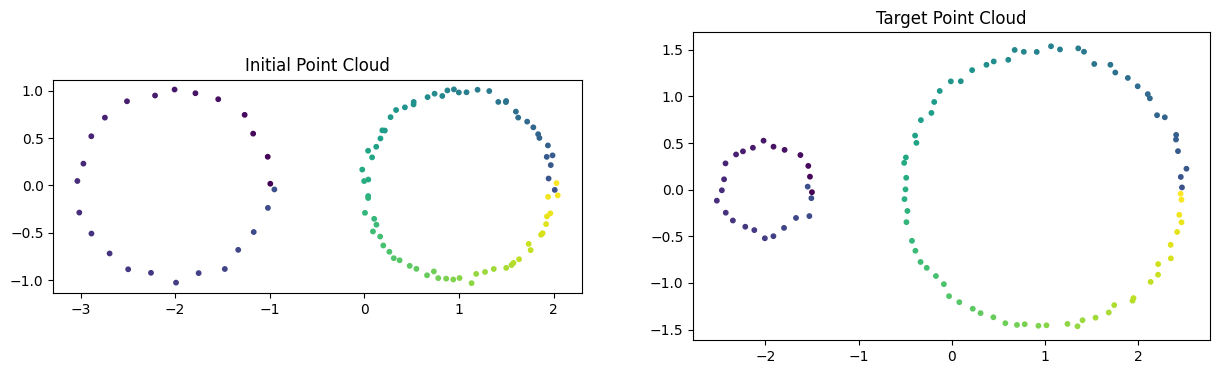

In [4]:
_X = get_initial_point_cloud()
Y = get_target_point_cloud()
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(_X[:, 0].numpy(), _X[:, 1].numpy(), s=10, c=np.arange(_X.size(0)), cmap='viridis')
ax1.set_title('Initial Point Cloud')
ax1.set_aspect('equal')
ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(Y[:, 0].numpy(), Y[:, 1].numpy(), s=10, c=np.arange(_X.size(0)), cmap='viridis')
ax2.set_title('Target Point Cloud')
ax2.set_aspect('equal')
plt.show()

In [5]:
lr = 1.
n_epochs = 100
n_trials = 10
n_samples = 50

loss_histories = []
X_histories = []

In [6]:
print("=== Gradient Descent ===")
X = _X.clone().requires_grad_()
optimizer = SGD([X], lr=lr)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)

loss_history = []
X_history = []
for epoch in range(n_epochs):
    loss = loss_inverting_hole_size(X, Y, n_trials, n_samples, grad_type="standard")
    
    loss_history.append(loss.item())
    X_history.append(X.clone().detach())
    print(f'Epoch {epoch}/{n_epochs}, Loss: {loss.item()}, lr: {optimizer.param_groups[0]["lr"]:.4f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

loss = loss_inverting_hole_size(X, Y, n_trials, n_samples, grad_type="standard")
print(f'Final Loss: {loss.item()}')
loss_history.append(loss.item())
X_history.append(X.clone().detach())

loss_histories.append(loss_history)
X_histories.append(X_history)

=== Gradient Descent ===


Epoch 0/100, Loss: 0.8624153137207031, lr: 1.0000
Epoch 1/100, Loss: 0.8856298327445984, lr: 0.9500
Epoch 2/100, Loss: 0.791479229927063, lr: 0.9025
Epoch 3/100, Loss: 0.9105879664421082, lr: 0.8574
Epoch 4/100, Loss: 0.862407386302948, lr: 0.8145
Epoch 5/100, Loss: 0.8719582557678223, lr: 0.7738
Epoch 6/100, Loss: 0.8067083358764648, lr: 0.7351
Epoch 7/100, Loss: 0.7950828075408936, lr: 0.6983
Epoch 8/100, Loss: 0.7857520580291748, lr: 0.6634
Epoch 9/100, Loss: 0.7970244884490967, lr: 0.6302
Epoch 10/100, Loss: 0.8228973150253296, lr: 0.5987
Epoch 11/100, Loss: 0.8782022595405579, lr: 0.5688
Epoch 12/100, Loss: 0.7948692440986633, lr: 0.5404
Epoch 13/100, Loss: 0.7896374464035034, lr: 0.5133
Epoch 14/100, Loss: 0.7948598861694336, lr: 0.4877
Epoch 15/100, Loss: 0.8145424127578735, lr: 0.4633
Epoch 16/100, Loss: 0.7694641351699829, lr: 0.4401
Epoch 17/100, Loss: 0.7800532579421997, lr: 0.4181
Epoch 18/100, Loss: 0.8315238952636719, lr: 0.3972
Epoch 19/100, Loss: 0.7466837763786316, lr:

In [7]:
print("=== Continuation ===")
X = _X.clone().requires_grad_()
optimizer = SGD([X], lr=lr)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)

loss_history = []
X_history = []
for epoch in range(n_epochs):
    loss = loss_inverting_hole_size(X, Y, n_trials, n_samples, grad_type="continuation")
    
    loss_history.append(loss.item())
    X_history.append(X.clone().detach())
    print(f'Epoch {epoch}/{n_epochs}, Loss: {loss.item()}, lr: {optimizer.param_groups[0]["lr"]:.4f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

loss = loss_inverting_hole_size(X, Y, n_trials, n_samples, grad_type="continuation")
print(f'Final Loss: {loss.item()}')
loss_history.append(loss.item())
X_history.append(X.clone().detach())

loss_histories.append(loss_history)
X_histories.append(X_history)

=== Continuation ===
Epoch 0/100, Loss: 0.8596779108047485, lr: 1.0000
Epoch 1/100, Loss: 0.8941623568534851, lr: 0.9500
Epoch 2/100, Loss: 0.8636186718940735, lr: 0.9025
Epoch 3/100, Loss: 0.8701946139335632, lr: 0.8574
Epoch 4/100, Loss: 0.8114248514175415, lr: 0.8145
Epoch 5/100, Loss: 0.7320967316627502, lr: 0.7738
Epoch 6/100, Loss: 0.7098130583763123, lr: 0.7351
Epoch 7/100, Loss: 0.6888585090637207, lr: 0.6983
Epoch 8/100, Loss: 0.6327624917030334, lr: 0.6634
Epoch 9/100, Loss: 0.5549615621566772, lr: 0.6302
Epoch 10/100, Loss: 0.5274888277053833, lr: 0.5987
Epoch 11/100, Loss: 0.49795636534690857, lr: 0.5688
Epoch 12/100, Loss: 0.4861745834350586, lr: 0.5404
Epoch 13/100, Loss: 0.43435072898864746, lr: 0.5133
Epoch 14/100, Loss: 0.4119551181793213, lr: 0.4877
Epoch 15/100, Loss: 0.39979782700538635, lr: 0.4633
Epoch 16/100, Loss: 0.33307144045829773, lr: 0.4401
Epoch 17/100, Loss: 0.3372194766998291, lr: 0.4181
Epoch 18/100, Loss: 0.3504721224308014, lr: 0.3972
Epoch 19/100, Lo

In [8]:
print("=== Big Step ===")
X = _X.clone().requires_grad_()
optimizer = SGD([X], lr=lr)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)

loss_history = []
X_history = []
for epoch in range(n_epochs):
    loss = loss_inverting_hole_size(X, Y, n_trials, n_samples, grad_type="bigstep")

    loss_history.append(loss.item())
    X_history.append(X.clone().detach())
    print(f'Epoch {epoch}/{n_epochs}, Loss: {loss.item()}, lr: {optimizer.param_groups[0]["lr"]:.4f}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

loss = loss_inverting_hole_size(X, Y, n_trials, n_samples, grad_type="bigstep")
print(f'Final Loss: {loss.item()}')
loss_history.append(loss.item())
X_history.append(X.clone().detach())

loss_histories.append(loss_history)
X_histories.append(X_history)

=== Big Step ===


Epoch 0/100, Loss: 0.8242615461349487, lr: 1.0000
Epoch 1/100, Loss: 0.7870391607284546, lr: 0.9500
Epoch 2/100, Loss: 0.6121862530708313, lr: 0.9025
Epoch 3/100, Loss: 0.4934716820716858, lr: 0.8574
Epoch 4/100, Loss: 0.3030344545841217, lr: 0.8145
Epoch 5/100, Loss: 0.4750327467918396, lr: 0.7738
Epoch 6/100, Loss: 0.38468146324157715, lr: 0.7351
Epoch 7/100, Loss: 0.29624930024147034, lr: 0.6983
Epoch 8/100, Loss: 0.4023779034614563, lr: 0.6634
Epoch 9/100, Loss: 0.3671014904975891, lr: 0.6302
Epoch 10/100, Loss: 0.3856264054775238, lr: 0.5987
Epoch 11/100, Loss: 0.396293044090271, lr: 0.5688
Epoch 12/100, Loss: 0.3540472686290741, lr: 0.5404
Epoch 13/100, Loss: 0.41479602456092834, lr: 0.5133
Epoch 14/100, Loss: 0.368511438369751, lr: 0.4877
Epoch 15/100, Loss: 0.39275068044662476, lr: 0.4633
Epoch 16/100, Loss: 0.3506339192390442, lr: 0.4401
Epoch 17/100, Loss: 0.398824006319046, lr: 0.4181
Epoch 18/100, Loss: 0.37947213649749756, lr: 0.3972
Epoch 19/100, Loss: 0.412564218044281, 

In [9]:
print("=== Diffeo ===")
X = _X.clone().requires_grad_()
optimizer = SGD([X], lr=lr)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)

loss_history = []
X_history = []
for epoch in range(n_epochs):
    loss = loss_inverting_hole_size(X, Y, n_trials, n_samples, grad_type="diffeo")
    
    loss_history.append(loss.item())
    X_history.append(X.clone().detach())
    print(f'Epoch {epoch}/{n_epochs}, Loss: {loss.item()}, lr: {optimizer.param_groups[0]["lr"]:.4f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

loss = loss_inverting_hole_size(X, Y, n_trials, n_samples, grad_type="diffeo")
print(f'Final Loss: {loss.item()}')
loss_history.append(loss.item())
X_history.append(X.clone().detach())

loss_histories.append(loss_history)
X_histories.append(X_history)

=== Diffeo ===
Epoch 0/100, Loss: 0.8872672915458679, lr: 1.0000
Epoch 1/100, Loss: 0.8489164113998413, lr: 0.9500
Epoch 2/100, Loss: 0.8539084196090698, lr: 0.9025
Epoch 3/100, Loss: 0.7272062301635742, lr: 0.8574
Epoch 4/100, Loss: 0.6873857975006104, lr: 0.8145
Epoch 5/100, Loss: 0.6663917303085327, lr: 0.7738
Epoch 6/100, Loss: 0.577997088432312, lr: 0.7351
Epoch 7/100, Loss: 0.47947007417678833, lr: 0.6983
Epoch 8/100, Loss: 0.4450572431087494, lr: 0.6634
Epoch 9/100, Loss: 0.39564064145088196, lr: 0.6302
Epoch 10/100, Loss: 0.37063246965408325, lr: 0.5987
Epoch 11/100, Loss: 0.3216281533241272, lr: 0.5688
Epoch 12/100, Loss: 0.32852187752723694, lr: 0.5404
Epoch 13/100, Loss: 0.30160361528396606, lr: 0.5133
Epoch 14/100, Loss: 0.29156607389450073, lr: 0.4877
Epoch 15/100, Loss: 0.2776368260383606, lr: 0.4633
Epoch 16/100, Loss: 0.24504224956035614, lr: 0.4401
Epoch 17/100, Loss: 0.2896146774291992, lr: 0.4181
Epoch 18/100, Loss: 0.23521378636360168, lr: 0.3972
Epoch 19/100, Loss:

/home/nishikawa/benchmark_ph_optimization/.venv/lib/python3.12/site-packages/gudhi/persistence_graphical_tools.py:129: UserWarning: usetex mode requires TeX.
  warnings.warn("usetex mode requires TeX.")


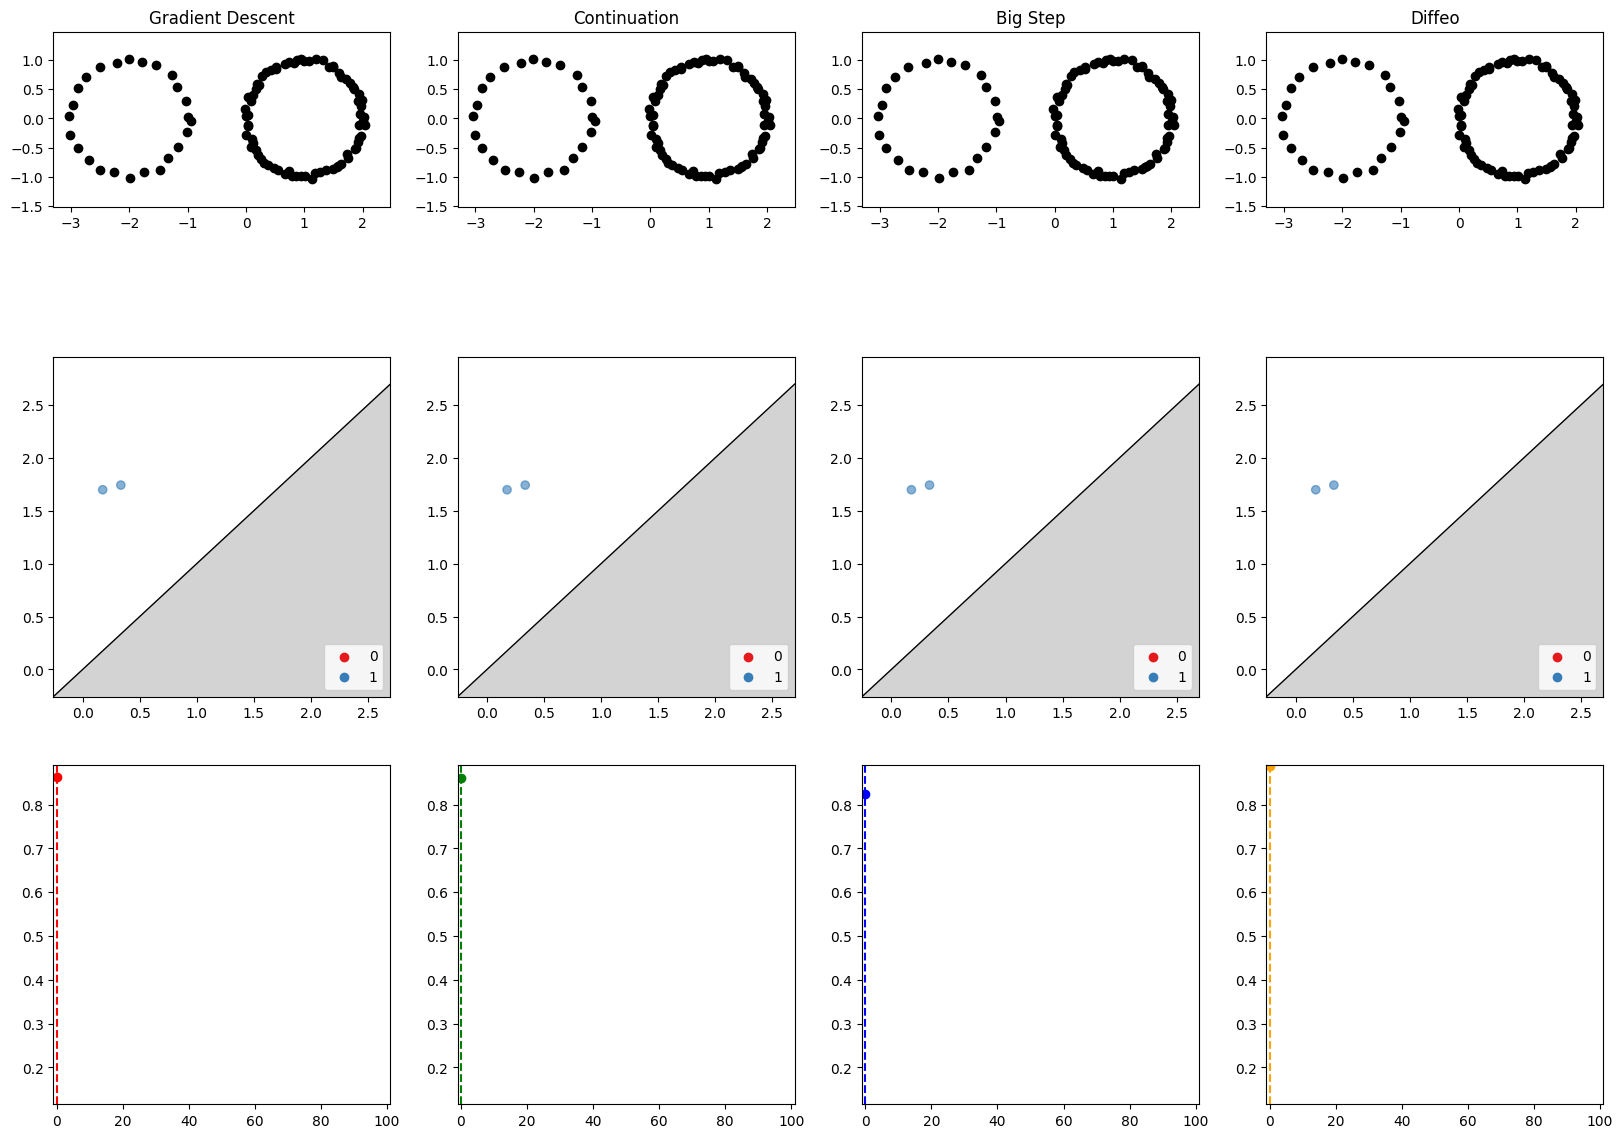

In [10]:
from ph_opt import get_animation

title_list = ["Gradient Descent", "Continuation", "Big Step", "Diffeo"]
loss_histories = [[obj] for obj in loss_histories]
ani = get_animation(X_histories, loss_histories, dim_list=[1], title_list=title_list)
ani.save("02_animation.gif", writer="pillow", fps=10)